1000 (0.3944638252408826, 1.5827948473807422e-52) 0.11275517264654883 0.019930713053529836


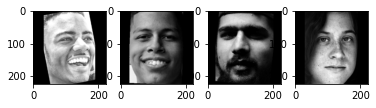

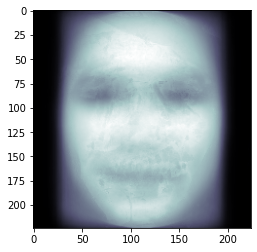

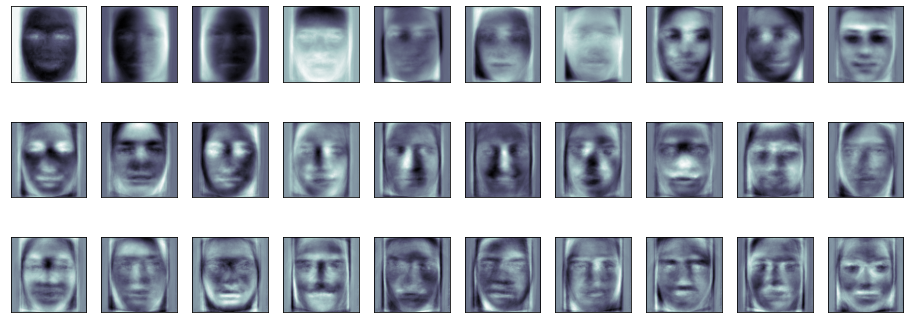

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import spatial

#prepare data with generic scores

txt1 = pd.read_csv('scores/train_2022.txt', sep=" ",  header = None)
txt2 = pd.read_csv('scores/test_2022.txt', sep=" ",  header = None)
txt3 = pd.read_csv('scores/val_2022.txt', sep=" ", header = None)
data = pd.concat([txt1,txt2,txt3])
data.columns = ['image', 'score']

data = data.sort_values(by=['score'])

# run eigenface + shallow predictor

n_training, acc, mae, rmse = eigenface(data,'score',train_number = 1000)

print(n_training, acc, mae, rmse)

In [44]:
#Eigenface + shallow predictor

from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt


def preprocess_data(faces_train, faces_test):
    # flatten the imagaes from 
    X_train =  np.reshape(faces_train,(faces_train.shape[0], -1 ))
    X_test =   np.reshape(faces_test, (faces_test.shape[0], -1 ))
    mu = np.mean(X_train, axis = 0 )
    std_dev = np.mean(X_train, axis = 0)
    std_dev_mod = np.copy(std_dev)
    std_dev_mod[std_dev == 0 ] = 1
    X_train = (X_train - mu)/std_dev_mod
    # normalize the test set with same mu and std values as training set 
    X_test = (X_test - mu)/std_dev_mod
    return X_train, X_test  


def preprocess_data2(faces_train, faces_test):
    
    
    normalised_train = np.ndarray(shape=(len(faces_train), 224*224))
    normalised_test = np.ndarray(shape=(len(faces_test), 224*224))
    
    mean_face = np.zeros((1,224*224))

    for i in faces_train:
       mean_face = np.add(mean_face,i)
    
    mean_face = np.divide(mean_face,float(len(faces_train))).flatten()

    plt.imshow(mean_face.reshape(224, 224), cmap='gray')
    
    for i in range(len(faces_train)):
       normalised_train[i] = np.subtract(faces_train[i],mean_face)
    
    for i in range(len(faces_test)):
       normalised_test[i] = np.subtract(faces_test[i],mean_face)
    
    return normalised_train, normalised_test


def eigenface(df,column, train_number = 100):
       k=0
       df = df.sample(frac=1).reset_index(drop=True)
       df['image'] =df['image'].str.replace('/home/ubuntu/ME-beautydatabase/images',
                                                '/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn') 
       
       min_max_scaler = preprocessing.MinMaxScaler()
    
       df[column] = min_max_scaler.fit_transform(df[column].values.reshape(-1,1))
    
       df2 = pd.DataFrame(columns = ['image', column, 'features'])
    
       for index, row in df.iterrows():

          try:
             
             img = Image.open(row['image']).convert('L')
             df2.loc[len(df2)]=[row['image'],row[column], np.asarray(img).flatten()]
                
          except:
            
             #print(row['image'])
             k+=k   
             pass
       
       
       #normalized_df=(df2-df2.mean())/df2.std()
       
       scaler = StandardScaler()
        
       train= df2[:train_number]
       test= df2[train_number:]
       #one_test = test.iloc[[55]]
       regressor = SVR(kernel = 'linear') 
        

       
       #train_X = (train['features'].values.tolist())    
       #test_X = (test['features'].values.tolist()) 

       train_X = min_max_scaler.fit_transform(train['features'].values.tolist())    
       test_X = min_max_scaler.fit_transform(test['features'].values.tolist())
       #train_X, test_X = preprocess_data2(train_X, test_X)
       train_Y = (train[column].values.tolist()) 
       test_Y = (test[column].values.tolist())
       #print(train_Y[10])
        
       fig = plt.figure()
       fig.add_subplot(1, 4, 1)
       plt.imshow(train_X[200].reshape(224,224), cmap='gray')
       fig.add_subplot(1, 4, 2)
       plt.imshow(train_X[300].reshape(224,224), cmap='gray')
       fig.add_subplot(1, 4, 3)
       plt.imshow(train_X[400].reshape(224,224), cmap='gray')
       fig.add_subplot(1, 4, 4)
       plt.imshow(train_X[500].reshape(224,224), cmap='gray') 
        
       n_components = 50
       pca = PCA(n_components = 50, whiten=True).fit(train_X)
       # apply PCA transformation
       X_train_pca = pca.transform(train_X)
       X_test_pca = pca.transform(test_X) 
      
       fig = plt.figure()
       plt.imshow(pca.mean_.reshape(224,224),
           cmap=plt.cm.bone)
    
       fig = plt.figure(figsize=(16, 6))
       for i in range(30):
           ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
           ax.imshow(pca.components_[i].reshape(224,224),
              cmap=plt.cm.bone)
    
       regressor.fit(X_train_pca, train_Y)
       #w = regressor.coef_.dot(np.asarray(one_test['features'].values.tolist()).reshape(512))
       result = regressor.predict(X_test_pca) 
       #print(result[:100])
       #print(result[55],w+regressor.intercept_)
       mae =  metrics.mean_absolute_error(test_Y, result)
       rmse = metrics.mean_squared_error(test_Y, result)
       return train_number, pearsonr(test_Y, result), mae, rmse
                                                   
             

In [86]:
# get Gabor, HOF, SIFT featutes

import numpy as np
from cv2 import cv2
import cv2 as cv
import os
from skimage.feature import hog

#import csv


EPS = 0.00000000000000001

def build_filters():
    filters = []

    # Size of Gabor kernel
    ksize = 31

    # For different orientations
    for theta in np.arange(0, np.pi, np.pi/4):
        # And different wavelengths of the sinusoidal factor
        for lamb in np.arange(np.pi/4, np.pi, np.pi/4):
            # Get a filter
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, lamb, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)

    return filters
 
# Given an image and a set of filters, derive the response matrices 
def process(img, filters):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100,100))

    responses = []
    # accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        responses.append(fimg)
        # np.maximum(accum, fimg, accum)

    return responses

# Given a response matrix, compute for the local energy
# Local Energy = summing up the squared value of each matrix value from a response matrix
def get_local_energy (matrix):
    local_energy = 0.0
    for row in range (len(matrix)):
        for col in range(len(matrix[0])):
            val = int(matrix[row][col]) * int(matrix[row][col])
            local_energy = local_energy + val

    # Divide by the highest possible value, which is 255^2 * (100 x 100)
    # to normalize values from 0 to 1, and replace 0s with EPS value to work with NB
    local_energy = local_energy / 650250000
    return EPS if local_energy == 0 else local_energy

# Given a response matrix, compute for the mean amplitude
# Mean Amplitude = sum of absolute values of each matrix value from a response matrix
def get_mean_amplitude (matrix):
    mean_amp = 0.0

    for row in range (len(matrix)):
        for col in range(len(matrix[0])):
            val = abs(int(matrix[row][col]))
            mean_amp = mean_amp + val

    # Divide by the highest possible value, which is 255 * (100 x 100)
    # to normalize values from 0 to 1, and replace 0s with EPS value to work with NB
    mean_amp = mean_amp / 2550000
    return EPS if mean_amp == 0 else mean_amp

# Return a list of images from the given directory
def load_images_from_folder (folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

# Get the feature vector (local energy/mean amplitude from response matrices) of an image
# This function is called when bulding the CSV files or when processing each frame
def get_image_feature_vector(image, filters, positive=None):
    response_matrices = process(image, filters)

    local_energy_results = []
    mean_amplitude_results = []

    for matrix in response_matrices:
        local_energy = get_local_energy(matrix)
        mean_amplitude = get_mean_amplitude(matrix)
        local_energy_results.append (local_energy)
        mean_amplitude_results.append(mean_amplitude)
        
    if positive is None:
        feature_set = local_energy_results + mean_amplitude_results
    else:
        pos_num = 1 if positive else 0
        feature_set = local_energy_results + mean_amplitude_results + [pos_num]

    return feature_set

# Get all feature vectors of a set of images, used when building the CSV files
def get_all_image_feature_vectors(df, column, features_type = "gabor"):
    filters = build_filters()
    feature_sets = []
    df2 = pd.DataFrame(columns = ['image', column, 'features'])
    
    for index, row  in df.iterrows():
        try: 
           img = cv2.imread(row['image'])

           
           if features_type == 'HOG1':  
            
              img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
              img = cv2.resize(img,(128,128))
              # compute HOG features
              features, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(4, 4), block_norm= 'L2',visualize=True)
           
           elif features_type == 'HOG2': 
                
              
              img=cv2.resize(img, (64, 128), interpolation=cv2.INTER_CUBIC)  
              hog_cv=cv2.HOGDescriptor()
              
              features=hog_cv.compute(img,winStride=(64,128),padding=(0,0))  
              features=features.transpose()
              features = np.squeeze(features)  
           elif features_type == 'SIFT':
             
              #not working right now
              
              sift = cv2.SIFT_create()
              # compute SIFT keypoints & descriptors for images
              kp, features= sift.detectAndCompute(img, None)
               
              features = features.flatten()
             
           else:
              
              features = get_image_feature_vector(img, filters, positive=False)   
            
           df2.loc[len(df2)] = [row['image'],row[column],features] 
        except:
           print(row['image'])
    return df2



import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import spatial

#prepare data with generic scores

txt1 = pd.read_csv('scores/train_2022.txt', sep=" ",  header = None)
txt2 = pd.read_csv('scores/test_2022.txt', sep=" ",  header = None)
txt3 = pd.read_csv('scores/val_2022.txt', sep=" ", header = None)
data = pd.concat([txt1,txt2,txt3])
data.columns = ['image', 'score']
data.image  = data.image.str.replace('/home/ubuntu/ME-beautydatabase/images/','/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/')

df = get_all_image_feature_vectors (data,'score',features_type = 'gabor')


                                                 image     score
0    /home/ubuntu/MEBeauty-database/images_crop_ali...  3.790123
1    /home/ubuntu/MEBeauty-database/images_crop_ali...  7.663194
2    /home/ubuntu/MEBeauty-database/images_crop_ali...  4.561957
3    /home/ubuntu/MEBeauty-database/images_crop_ali...  5.960920
4    /home/ubuntu/MEBeauty-database/images_crop_ali...  5.046717
..                                                 ...       ...
225  /home/ubuntu/MEBeauty-database/images_crop_ali...  7.405896
226  /home/ubuntu/MEBeauty-database/images_crop_ali...  6.100000
227  /home/ubuntu/MEBeauty-database/images_crop_ali...  7.427273
228  /home/ubuntu/MEBeauty-database/images_crop_ali...  4.888889
229  /home/ubuntu/MEBeauty-database/images_crop_ali...  6.460268

[2553 rows x 2 columns]
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/caucasian/g_7.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/ashkan-forouzani-lxQw4HiwKBY-unsplash.jpg
/home/ub

/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/caucasian/boy-1105361_1920.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/hadi-yazdi-aznaveh-TmRQRgugEsQ-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/asian/tanjir-ahmed-chowdhury-YMJvX8k3Kfc-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/md-duran-msnDjv5cC_U-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/pexels-the-baljinder-4089881.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/female/caucasian/charlize-theron-669608_1280.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/pexels-prince-photos-1537517.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/sammy-chandio-EvdFPEFqoxk-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/puvvukonvict-photography-0M_Aej4dRWU-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/m

/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/pexels-anna-tarazevich-5119607.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/female/indian/pexels-nh-noyon-4250862.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/suranjan-koirala-95-3iy_pj2I-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/ashkan-forouzani-b8dhPVAxWfE-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/man-5465729_1920.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/muhammad-murtaza-ghani-ShxuPMbO1lM-unsplash.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/caucasian/g_9.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/people-2456350_1920.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/guy3.jpg
/home/ubuntu/MEBeauty-database/images_crop_align_mtcnn/male/indian/portrait-1469500_1920.jpg
/home/ubuntu/MEBeauty-database/images_crop

In [18]:
       # run predictor on gabor/sift/hog/geom. feautres
    
       from sklearn.svm import SVR
       from sklearn.pipeline import make_pipeline
       from sklearn.preprocessing import StandardScaler
       from scipy.stats import pearsonr
       import sklearn.metrics as metrics
       from sklearn import preprocessing
       column = 'score'
       df = df3
       df = df.sample(frac=1).reset_index(drop=True)
       
       min_max_scaler = preprocessing.MinMaxScaler()
    
       df[column] = min_max_scaler.fit_transform(df[column].values.reshape(-1,1))  
    
       
       train_number = 1000
       train= df[:train_number]
       test= df[train_number:]
       regressor = SVR(kernel = 'rbf')
       #print(train['features'].values.shape) 
       train_X = (train['features'].values.tolist()) 
    
       test_X = (test['features'].values.tolist())
       #train_X = min_max_scaler.fit_transform(train['features'].values.tolist())    
       #test_X = min_max_scaler.fit_transform(test['features'].values.tolist())
       train_Y = (train[column].values.tolist()) 
       test_Y = (test[column].values.tolist())
      
       #print(train_Y[:60])
        
       regressor.fit(train_X, train_Y)
       #w = regressor.coef_.dot(np.asarray(one_test['features'].values.tolist()).reshape(512))
       result = regressor.predict(test_X) 
       print(result[:100])
       #print(result[55],w+regressor.intercept_)
       mae =  metrics.mean_absolute_error(test_Y, result)
       rmse = metrics.mean_squared_error(test_Y, result)
       PC = pearsonr(test_Y, result)
       PC,mae,rmse

[0.50968491 0.67196697 0.54224531 0.69459995 0.56789583 0.57511399
 0.71607233 0.6658769  0.69396375 0.53169316 0.6953647  0.65090284
 0.57565519 0.47954009 0.61160625 0.50432093 0.67649496 0.53342883
 0.53726154 0.73710644 0.49917686 0.60401842 0.63983306 0.57549274
 0.40757595 0.65435298 0.67676229 0.71085064 0.65615769 0.68939568
 0.74454481 0.70045737 0.70502182 0.5086236  0.52564775 0.63778172
 0.4918617  0.5658015  0.61186214 0.50661578 0.6139842  0.68443585
 0.57434045 0.65988083 0.66737858 0.62592029 0.68988869 0.69542703
 0.6498153  0.6554455  0.65431593 0.63846908 0.52146831 0.68315547
 0.67035339 0.55340934 0.50904542 0.5764081  0.52221324 0.69471951
 0.64399879 0.65759378 0.68182251 0.5054738  0.59486689 0.71199352
 0.50966935 0.51437159 0.58651291 0.70540175 0.68183581 0.40731446
 0.69206591 0.55200693 0.59486689 0.60463376 0.59800378 0.65378648
 0.53442932 0.62509096 0.64336314 0.70003206 0.53488121 0.66264057
 0.74538741 0.68467388 0.6195853  0.62433281 0.65794447 0.6445

((0.5457768297161613, 4.972035100312956e-114),
 0.10399924546645406,
 0.01729425531535664)

In [16]:
# get geometric feautres based on landmarks

import math
import numpy
import itertools

def facialRatio(points):
	x1 = points[0];
	y1 = points[1];
	x2 = points[2];
	y2 = points[3];
	x3 = points[4];
	y3 = points[5];
	x4 = points[6];
	y4 = points[7];

	dist1 = math.sqrt((x1-x2)**2 + (y1-y2)**2)
	dist2 = math.sqrt((x3-x4)**2 + (y3-y4)**2)

	ratio = dist1/dist2

	return ratio


def generateFeatures(pointIndices1, pointIndices2, pointIndices3, pointIndices4, allLandmarkCoordinates):
	size = allLandmarkCoordinates.shape
	allFeatures = numpy.zeros((size[0], len(pointIndices1)))
	
	for x in range(0, size[0]):
		landmarkCoordinates = allLandmarkCoordinates[x, :]
		ratios = [];
		for i in range(0, len(pointIndices1)):
			x1 = landmarkCoordinates[2*(pointIndices1[i]-1)]
			y1 = landmarkCoordinates[2*pointIndices1[i] - 1]
			x2 = landmarkCoordinates[2*(pointIndices2[i]-1)]
			y2 = landmarkCoordinates[2*pointIndices2[i] - 1]

			x3 = landmarkCoordinates[2*(pointIndices3[i]-1)]
			y3 = landmarkCoordinates[2*pointIndices3[i] - 1]
			x4 = landmarkCoordinates[2*(pointIndices4[i]-1)]
			y4 = landmarkCoordinates[2*pointIndices4[i] - 1]

			points = [x1, y1, x2, y2, x3, y3, x4, y4]
			ratios.append(facialRatio(points))
		allFeatures[x, :] = numpy.asarray(ratios)
	return allFeatures


def generateAllFeatures(allLandmarkCoordinates):
	a = [18, 22, 23, 27, 37, 40, 43, 46, 28, 32, 34, 36, 5, 9, 13, 49, 55, 52, 58]
	combinations = itertools.combinations(a, 4)
	i = 0
	pointIndices1 = [];
	pointIndices2 = [];
	pointIndices3 = [];
	pointIndices4 = [];

	for combination in combinations:
		pointIndices1.append(combination[0])
		pointIndices2.append(combination[1])
		pointIndices3.append(combination[2])
		pointIndices4.append(combination[3])
		i = i+1
		pointIndices1.append(combination[0])
		pointIndices2.append(combination[2])
		pointIndices3.append(combination[1])
		pointIndices4.append(combination[3])
		i = i+1
		pointIndices1.append(combination[0])
		pointIndices2.append(combination[3])
		pointIndices3.append(combination[1])
		pointIndices4.append(combination[2])
		i = i+1

	return generateFeatures(pointIndices1, pointIndices2, pointIndices3, pointIndices4, allLandmarkCoordinates)


df3 = pd.DataFrame(columns = ['image', 'score', 'features'])
    
for index, row in df.iterrows(): 
    
   #features = numpy.loadtxt(row['landmarks'], dtype=int, usecols=range(136))
   landmarks = numpy.fromstring(row['landmarks'], dtype=int, sep=',')
   landmarks = numpy.expand_dims(landmarks, axis=0) 
    
   featuresALL = generateAllFeatures(landmarks)
   #print(featuresALL)
   df3.loc[len(df3)]=[row['image'],row['score'], featuresALL.squeeze()]


[[1.39222948 1.24873707 5.28318865 ... 3.17234177 1.34612552 1.78885438]]
[[0.89459939 0.93044285 4.45861488 ... 3.58448986 0.77250547 0.95213401]]
[[0.64374683 0.75959025 4.3687381  ... 3.25808139 0.57259833 0.73351779]]
[[0.58733844 0.73154029 4.00707685 ... 3.58276526 0.50187722 0.62781848]]
[[0.98966192 0.98539421 5.16822521 ... 2.48836873 0.85193107 1.15354572]]
[[1.00146235 1.00126491 4.10964917 ... 2.83116888 0.77018894 1.01439454]]
[[1.83160806 1.51012598 5.52342256 ... 2.03882435 1.80489388 1.77316237]]
[[0.58085942 0.70950823 4.49350244 ... 2.60448834 0.48861886 0.79957854]]
[[0.80016371 0.85246889 6.26546344 ... 2.12142699 0.86054665 0.72138965]]
[[0.45862642 0.58990837 5.66554771 ... 3.95904447 0.39599538 0.55787175]]
[[0.44673819 0.58831681 4.99060235 ... 2.1814451  0.40212247 0.67258667]]
[[0.60125878 0.71581984 4.64731994 ... 1.91204835 0.48663661 0.81623118]]
[[0.54561233 0.65466175 5.50802957 ... 3.37990568 0.41401702 0.70919573]]
[[0.98572282 0.99341748 8.05471156 ...

[[0.67035952 0.78264124 4.23996816 ... 2.46504221 0.54866285 0.88844012]]
[[ 1.47918636  1.39078367 10.58012562 ...  2.9183537   1.42720191
   1.51450207]]
[[1.02565563 1.01873109 6.49886521 ... 3.63192773 0.95588744 1.12626171]]
[[0.5451609  0.67803167 4.83940696 ... 2.01227472 0.59003327 0.5903403 ]]
[[1.40113548 1.31876593 8.04182358 ... 4.44722135 1.4615916  1.28312464]]
[[1.82070919 1.52107064 5.99914836 ... 3.88935365 1.74427635 1.49492503]]
[[0.4684904  0.59323574 5.82725994 ... 2.50259534 0.57402522 0.76488086]]
[[1.01591526 1.01316971 8.3643769  ... 3.15047207 0.89138684 1.25640213]]
[[0.89348093 0.9235397  6.08157827 ... 2.12855719 0.92797819 0.93348499]]
[[0.80295143 0.85952341 5.95542845 ... 3.02705747 0.79506248 0.852959  ]]
[[0.63455711 0.69944468 8.2941485  ... 3.41645008 0.54927815 0.6848008 ]]
[[1.70018381 1.40789785 4.86487799 ... 2.99918688 1.5328452  2.1107004 ]]
[[0.4449177  0.58691065 5.31220408 ... 2.50991724 0.53518427 0.45311117]]
[[0.84238173 0.89333576 4.7036

[[1.00035549 1.00033659 5.41014445 ... 2.34508112 0.89218687 1.01181725]]
[[2.09983304 1.53847925 3.99020152 ... 2.08819542 1.89754345 2.04166578]]
[[2.65543807 2.00693243 5.86692356 ... 1.5588032  2.55157924 3.03503038]]
[[0.47608189 0.5766113  6.89760271 ... 2.23844832 0.54067484 0.55991832]]
[[1.86577921 1.51146478 5.07859028 ... 1.88726591 1.61167707 2.31540733]]
[[0.9012004  0.93660962 4.17646338 ... 2.90456869 0.80622577 1.10641267]]
[[0.77066329 0.84578528 5.43517628 ... 3.03205806 0.90553851 0.8203721 ]]
[[1.00991209 1.00406051 5.78016791 ... 4.21900462 1.07691662 1.01408993]]
[[1.26326385 1.17796858 5.59778377 ... 2.94540401 0.9601989  1.41742682]]
[[0.60233084 0.67792182 6.91003717 ... 3.18905991 0.47307412 0.68190106]]
[[1.06796652 1.05086704 7.18890311 ... 3.29231169 0.97592645 1.22290708]]
[[0.45714454 0.57210383 6.70505859 ... 2.15862949 0.62901681 0.67278696]]
[[1.24380462 1.17052446 6.05328434 ... 2.73342367 1.05807761 1.50522496]]
[[1.81790907 1.431662   4.21209779 ...

[[0.85169606 0.89365199 5.62534721 ... 2.6769039  0.74779313 1.175567  ]]
[[0.64221261 0.74174183 6.15199015 ... 4.86224015 0.59591103 0.47368598]]
[[0.50595274 0.62754473 5.44570559 ... 3.03115458 0.47901287 0.594071  ]]
[[1.04403065 1.02840679 5.36269605 ... 2.60441835 1.05868745 1.09570949]]
[[0.48923351 0.62027419 5.45839366 ... 1.72229593 0.48740423 0.55202398]]
[[0.93587987 0.9527686  6.26304087 ... 3.33114871 0.86439734 1.01455844]]
[[0.93099809 0.94577449 6.70264698 ... 2.99786932 0.83713545 1.0728203 ]]
[[1.1385362  1.09006206 4.98987823 ... 4.80832611 0.97925227 1.16810244]]
[[1.0712124  1.04961202 5.8498571  ... 1.34422122 0.69686776 1.55392427]]
[[0.51775275 0.64860365 5.03490705 ... 2.15182361 0.50110988 0.63585194]]
[[1.72112293 1.46725541 5.98777018 ... 3.08943134 1.49798019 1.69419096]]
[[0.46524846 0.61964236 4.57685362 ... 1.92052019 0.6648225  0.56922669]]
[[1.07727238 1.05419509 5.77703364 ... 3.2829526  0.93530617 1.10541627]]
[[2.21455307 1.55784707 3.6348535  ...

[[2.89507412 2.11966324 5.60482493 ... 2.22856153 1.88772708 2.20620188]]
[[1.10193417 1.05571741 4.13990255 ... 3.36883221 1.03409045 1.22187273]]
[[1.629002   1.43750742 6.94379624 ... 2.6493715  1.53910768 2.43478475]]
[[1.32215005 1.21336151 5.41740093 ... 3.10160483 0.97353318 1.44776033]]
[[1.07748988 1.05292953 5.80958599 ... 4.7721139  0.94243897 1.23173039]]
[[1.09341425 1.05610062 4.12285319 ... 1.64504494 0.94311195 1.06293662]]
[[0.78081075 0.84638219 5.32148684 ... 2.39751474 0.71389371 0.77336564]]
[[1.06274683 1.04194669 5.08379701 ... 3.09303263 0.8823255  1.22722804]]
[[0.43704832 0.56732634 5.81007267 ... 1.83185826 0.58241751 0.32366237]]
[[1.12714196 1.08849194 5.44       ... 3.40147027 1.05652227 1.05470218]]
[[1.41195394 1.29010719 6.87669451 ... 3.06061873 1.31334613 1.42431377]]
[[1.11299777 1.07431506 4.9822556  ... 3.02828742 0.81552974 1.13255062]]
[[1.05061082 1.03684272 6.31922415 ... 2.44178173 0.91520637 1.04898328]]
[[0.51484403 0.62990658 5.89514271 ...

[[1.00546452 1.00562223 6.95854164 ... 4.94399671 0.93465201 1.06145184]]
[[1.30500737 1.17820167 4.23809524 ... 3.56291168 1.26746208 1.53186368]]
[[0.6090813  0.73196738 4.29416689 ... 3.75255688 0.59134653 0.68746785]]
[[0.59429346 0.71473991 4.81354068 ... 1.91470694 0.72395427 0.70224688]]
[[1.1614723  1.10461728 4.97475378 ... 3.40511785 0.92221049 0.98617385]]
[[1.01335043 1.01089529 4.73737199 ... 2.25836874 0.83966314 1.14420786]]
[[1.43897379 1.29032263 6.0136854  ... 2.0899447  1.37674429 1.25120987]]
[[1.10085318 1.07733494 8.17539683 ... 3.80131556 1.01443644 1.09461666]]
[[0.86696066 0.90255674 6.16375399 ... 4.96417184 0.80588952 0.93172287]]
[[0.72306753 0.78440121 7.08614727 ... 3.03638231 0.64743964 0.76947112]]
[[0.65425287 0.75320495 5.03413009 ... 2.70094094 0.5875658  0.9000105 ]]
[[0.99583831 0.99941028 6.00231437 ... 2.70197217 1.12269265 1.00062403]]
[[1.07481432 1.05018648 4.86476021 ... 3.31856695 1.10769066 1.20066517]]
[[1.06559621 1.0419781  4.58424503 ...

[[1.21617607 1.15474419 7.00404196 ... 2.16233107 0.91493392 1.36412321]]
[[1.92710613 1.5510907  5.46331337 ... 1.39098917 1.83612889 1.3234005 ]]
[[1.12810554 1.09738954 7.63421574 ... 4.24426112 1.24246941 1.40517054]]
[[0.81356854 0.87120671 5.19249458 ... 2.1909597  0.70741968 1.07544578]]
[[1.10785757 1.07154569 4.82225108 ... 3.27218833 1.08399172 1.17547554]]
[[1.04822485 1.03235334 6.71510624 ... 4.39029513 1.03474665 1.01180607]]
[[0.90900442 0.9282974  7.3901542  ... 3.45786756 0.83775585 0.97999798]]
[[1.47074548 1.31371814 5.69360361 ... 2.74636914 0.90507532 1.64792444]]
[[1.52679022 1.33535273 5.45360682 ... 2.54111552 1.2463641  1.7685993 ]]
[[1.22699551 1.12422879 3.67914154 ... 3.79558741 1.01664647 1.25330333]]
[[0.7302818  0.80698626 5.07163754 ... 3.682982   0.62048102 0.61910307]]
[[0.92689962 0.95142979 4.63722773 ... 2.9317732  0.99141205 0.82972172]]
[[0.94631172 0.96933171 4.8434893  ... 3.0423675  0.85039753 1.03142758]]
[[0.79001117 0.84947864 5.61453619 ...

[[0.67003634 0.77504164 4.58325281 ... 3.32981006 0.65426559 0.80561198]]
[[0.77651968 0.84340363 5.16381039 ... 2.82475464 0.75895967 0.84335639]]
[[1.25652338 1.17229908 5.42175941 ... 3.45491394 1.35382484 1.70615325]]
[[0.75781505 0.82914265 5.20995647 ... 3.91014785 0.8099602  0.94283677]]
[[1.21429647 1.14230181 5.2157659  ... 2.51160286 0.90789848 1.48743874]]
[[1.92884017 1.51761333 4.41021541 ... 3.61022269 1.60898763 2.64941438]]
[[0.91795956 0.9494801  5.93099814 ... 3.40637913 0.86744795 1.03688723]]
[[0.9649673  0.98115061 4.89612548 ... 3.1763223  0.84786647 1.0942217 ]]
[[0.91241854 0.94253964 4.59529978 ... 3.66443396 0.86608367 1.03711608]]
[[0.61272158 0.71199851 5.81598673 ... 2.80079354 0.70471924 0.65374427]]
[[1.10539382 1.07733468 5.52598448 ... 2.62261444 1.05850307 1.12221215]]
[[1.2563353  1.17038586 4.83176632 ... 2.68028549 1.23057647 1.28298744]]
[[2.39995985 1.79890286 5.07808547 ... 2.38718037 1.83966839 2.67104526]]
[[1.1839692  1.11303932 4.16185285 ...

[[1.97283174 1.67553404 7.35252562 ... 1.98610558 2.16446273 1.89613678]]
[[0.40857128 0.53276271 6.30589758 ... 2.0110107  0.26402662 0.4730016 ]]
[[1.00606932 1.         7.94352236 ... 5.49018506 0.97506314 0.91500669]]
[[1.22660843 1.1439826  5.1101274  ... 3.2378636  1.18639649 1.16183405]]
[[1.07713268 1.06030085 6.09705118 ... 2.20499969 1.00044474 1.12921517]]
[[1.00586724 1.00281273 4.59280986 ... 2.23986678 1.         1.        ]]
[[1.22288649 1.14240106 4.56777767 ... 2.32495277 0.95697111 1.39960541]]
[[1.03647587 1.02867723 6.84275418 ... 5.95165064 0.90234872 1.04095143]]
[[0.93329423 0.95326151 5.72028543 ... 1.40254681 0.68069396 1.54028611]]
[[1.21474679 1.1422519  5.28825161 ... 2.61373488 0.99410459 1.27752709]]
[[0.64714097 0.73073226 6.36697386 ... 2.44135364 0.75333088 0.65862972]]
[[1.01395138 1.01465871 4.79917955 ... 2.16040729 0.88929729 1.11303796]]
[[2.88410945 2.17468402 7.0652336  ... 2.08767371 2.21077888 3.68488512]]
[[0.62576556 0.72755431 5.31238305 ...

[[ 1.21638474  1.20182864 15.91033906 ...  2.9098701   1.27804619
   1.28670558]]
[[1.79926001 1.48758129 5.46276616 ... 3.55592858 1.7739767  1.80875784]]
[[0.95120491 0.96115739 5.23303119 ... 2.68731919 0.87484903 0.98264761]]
[[0.85810956 0.90457631 4.90460043 ... 2.69730282 0.92655275 1.01939349]]
[[0.94129135 0.96323623 5.68685745 ... 2.5620114  0.97957713 0.97852063]]
[[0.89701927 0.92604856 5.73933004 ... 2.27659574 0.78379542 0.96370601]]
[[1.10441176 1.06384822 4.51076131 ... 2.58520977 0.9913543  1.28056641]]
[[0.64460081 0.70781275 8.67052109 ... 3.04708154 0.72270139 0.69565396]]
[[0.53218343 0.6841201  4.16224991 ... 3.73414687 0.50644308 0.60723911]]
[[1.34012341 1.25320519 6.81659588 ... 2.70519934 1.27275477 1.35631285]]
[[0.70623327 0.78851168 5.81258581 ... 3.04568043 0.59920818 0.73862178]]
[[0.47612014 0.62055502 4.79607916 ... 3.00665928 0.4935109  0.52603453]]
[[1.27668099 1.19049553 5.90447168 ... 1.75397116 1.01965015 1.73561304]]
[[1.12606408 1.09092618 6.9145

[[0.58669724 0.71728042 4.44546535 ... 2.99497296 0.54457818 0.67630804]]
[[1.73403642 1.46613668 5.91034066 ... 2.37582223 1.32455593 1.97268935]]
[[0.87694607 0.90534773 9.54951067 ... 2.51491453 0.67656179 1.06133444]]
[[1.12213343 1.08743927 6.18525003 ... 2.96360616 1.0236302  1.19405278]]
[[1.80674293 1.5        5.54581802 ... 3.18750723 1.44681321 1.93320082]]
[[1.0623802  1.04226656 4.4611793  ... 3.17549309 0.98431774 1.30379552]]
[[0.89886885 0.9394771  3.81565118 ... 2.39812245 0.74312442 1.19321557]]
[[1.86493786 1.42607344 3.72258838 ... 3.12234035 1.40276887 2.25231976]]
[[1.08586752 1.05076441 4.09172883 ... 2.85185185 1.05626337 1.30329856]]
[[1.09180495 1.06168843 5.12738131 ... 1.45656303 0.85789397 1.36652966]]
[[1.11651468 1.08125071 4.97332333 ... 3.20864784 1.40863287 1.01115968]]
[[1.05975324 1.04070534 5.30574762 ... 3.33214925 0.90521398 1.05347583]]
[[0.81473194 0.87313039 4.9665171  ... 3.56249323 0.65290536 0.91458623]]
[[1.03192723 1.01986266 4.3471095  ...

[[0.56049866 0.65048674 7.36713195 ... 2.52217975 0.73060023 0.5926165 ]]
[[1.02735913 1.01809472 5.75979893 ... 3.29539356 0.87126474 1.09817586]]
[[1.21130277 1.13005357 4.65814018 ... 1.69659501 1.09426737 1.38331655]]
[[1.24478593 1.15421608 4.81494991 ... 2.26706725 1.15146553 1.34771159]]
[[2.68644396 1.79217697 4.23575328 ... 3.74092576 2.07054485 3.46449169]]
[[1.32201206 1.23184204 6.83139206 ... 4.70106371 1.08039798 1.27110996]]
[[ 0.99415883  0.99798224 10.63014581 ...  3.02883771  1.13833098
   1.18263038]]
[[1.12583502 1.07405755 3.83426767 ... 2.63437895 1.17038882 1.14545579]]
[[1.16325864 1.10966662 5.60056605 ... 2.68933023 0.84726698 1.27994111]]
[[1.38711312 1.22284261 4.25234435 ... 1.90203771 0.9970437  1.73079054]]
[[2.17119988 1.65188162 5.02509296 ... 1.76691913 1.16442361 1.55926497]]
[[0.71571183 0.79951506 4.98681188 ... 2.6925824  0.65220078 0.7577849 ]]
[[0.44786269 0.57579796 5.82238405 ... 3.44532586 0.40948141 0.49345807]]
[[1.05689626 1.03837026 5.2941

[[1.42601265 1.25744998 4.74559781 ... 2.02515521 1.12844716 1.52069063]]
[[1.06179828 1.04611051 6.70359315 ... 3.66096365 0.95408085 1.23943095]]
[[0.99177047 0.99427388 5.14384184 ... 4.70669702 0.93349201 1.09515867]]
[[1.02584121 1.01381943 3.54995777 ... 3.24482034 0.94471995 1.13773007]]
[[1.02219731 1.00918632 6.8402654  ... 1.39116615 0.96025883 1.01524958]]
[[1.59766215 1.35608042 4.73991193 ... 2.42039047 1.18811977 1.6850236 ]]
[[1.11863672 1.08129249 4.45193694 ... 1.67387161 1.32189441 1.27258939]]
[[1.48570423 1.34234871 6.71651237 ... 2.97067496 1.24736457 1.76347472]]
[[0.94895981 0.96578818 5.94919189 ... 3.68579105 1.01508887 0.83337516]]
[[0.95641038 0.96966677 5.14950786 ... 2.         0.93775126 1.06638086]]
[[1.83165493 1.52699712 5.61128207 ... 2.50993832 2.41104018 1.98776747]]
[[1.53924691 1.38125785 7.09663752 ... 4.19290923 1.27330349 1.6142058 ]]
[[0.99063726 0.98457773 5.12692943 ... 2.24557421 0.98436182 0.84636864]]
[[2.12410789 1.74787241 6.90284878 ...

[[0.68156919 0.76804273 5.27859401 ... 2.22838685 0.65075775 0.79712302]]
[[0.30138347 0.39180351 8.32346082 ... 4.87058803 0.14652113 0.20664155]]
[[2.34332752 1.74921017 5.12047173 ... 2.86295857 1.94609508 2.7202941 ]]
[[0.49224951 0.59753027 6.88288367 ... 1.63674781 0.75595233 0.55368017]]
[[0.55404919 0.67656404 5.13524729 ... 1.73171705 0.53638854 0.59709906]]
[[1.01684799 1.01669632 6.11129767 ... 3.00080118 1.1258662  1.44301251]]
[[1.25239262 1.15487189 4.58748218 ... 1.99386031 1.06899889 1.06862334]]
[[2.3649105  1.81031652 5.973378   ... 2.16035831 2.32408883 1.8573519 ]]
[[1.40697969 1.25796902 5.15136733 ... 2.27336055 1.00079177 1.76878811]]
[[0.85651715 0.89455643 6.04476633 ... 1.84511271 0.72355332 0.85861882]]
[[1.14198758 1.09557105 5.29042093 ... 2.80573366 1.11184919 1.43060184]]
[[1.19026406 1.13285658 5.98552907 ... 4.38264157 1.35412613 1.15197163]]
[[0.91864536 0.93930755 5.83317087 ... 2.96672544 0.84185995 0.94452889]]
[[0.93102751 0.95740747 7.6397176  ...

[[0.44578174 0.54311602 6.81552107 ... 2.04918447 0.46526884 0.50029461]]
[[0.63765296 0.71151181 7.2690099  ... 4.44457213 0.55626437 0.5       ]]
[[0.48734815 0.63703799 4.54837728 ... 1.92025609 0.40629427 0.68701506]]
[[0.82870391 0.86882882 6.89053351 ... 2.23657405 0.81089545 1.07562277]]
[[1.14403826 1.12262822 5.74924113 ... 2.2763305  1.42165495 0.91122328]]
[[0.98395141 0.98962317 4.27763824 ... 2.68770977 0.89140717 1.12870036]]
[[1.26326385 1.17796858 5.59778377 ... 2.94540401 0.9601989  1.41742682]]
[[0.57882952 0.66313634 6.82123478 ... 3.79426363 0.59272123 0.76338629]]
[[0.37296018 0.46958514 8.56231889 ... 2.54509502 0.4469856  0.49621207]]
[[0.86199338 0.9043231  5.74673481 ... 4.3770413  0.93410712 1.02878285]]
[[2.09529089 1.69242982 6.34352767 ... 2.5646058  1.37589817 2.72750749]]
[[0.93881906 0.95724458 5.34017023 ... 2.08805918 0.76739096 1.14771622]]
[[1.11920846 1.0822643  5.18547868 ... 4.29351215 1.03533785 1.20540095]]
[[1.13141621 1.093882   5.9591612  ...

[[0.5352896  0.66056039 5.24456128 ... 2.56112225 0.59087523 0.58314345]]
[[0.99238201 0.99647322 5.11179041 ... 2.37814675 0.9931506  0.91243936]]
[[1.18456403 1.13351661 6.70602736 ... 4.78539445 1.13967887 1.12841021]]
[[1.05434089 1.03579468 4.97331909 ... 3.29269378 1.05581218 1.19141472]]
[[0.80375594 0.88081419 4.09352874 ... 5.07953976 0.6946989  0.75343708]]
[[1.58797708 1.35095124 4.76875131 ... 2.48399838 1.51617023 1.5       ]]
[[0.52292342 0.63378807 5.77925748 ... 1.82736236 0.39775879 0.98309147]]
[[0.45193781 0.59464275 5.23802664 ... 1.73736307 0.62181328 0.40945111]]
[[1.15658062 1.11214911 7.0048823  ... 3.16227766 0.99746443 1.21172433]]
[[0.97821521 0.98590134 5.13655673 ... 3.8943361  0.9118162  1.054772  ]]
[[0.91491685 0.93236879 4.45211206 ... 4.2653687  0.91673279 1.12957859]]
[[1.17818752 1.11975211 4.60977223 ... 2.17229554 0.94393392 1.5026643 ]]
[[0.73665426 0.80560807 5.88133501 ... 2.4600466  0.57284754 0.8666496 ]]
[[1.05862631 1.0424734  5.20887252 ...

[[0.646131   0.74490473 5.26902263 ... 4.30280733 0.61537495 0.66191011]]
[[0.89318451 0.93146883 4.3587043  ... 4.57894737 0.81177297 1.00047159]]
[[0.8527823  0.90271409 4.59432184 ... 3.09975464 0.73718944 0.94425488]]
[[ 1.77214868  1.5207481   6.75642737 ... 10.154559    1.52677924
   1.69458597]]
[[0.96237022 0.97710343 4.83803799 ... 2.54633412 0.99323173 1.13277793]]
[[1.19080981 1.11429705 4.27769714 ... 3.36963044 1.06973096 1.24885268]]
[[0.96925583 0.98056332 6.39644752 ... 4.28809458 1.03087722 1.05261579]]
[[0.83748964 0.88566168 5.39460563 ... 2.65299919 0.8174917  0.81465555]]
[[0.57484637 0.69889251 4.86486925 ... 2.53907617 0.51524123 0.62311425]]
[[0.41113848 0.53284647 5.98818518 ... 2.6        0.35311228 0.61296211]]
[[1.0223049  1.01639174 5.35326437 ... 2.96878252 0.89965464 1.23641129]]
[[1.01726892 0.99716052 7.96755922 ... 3.16285467 1.02717183 0.94926606]]
[[0.95752509 0.96414742 7.85670637 ... 5.12239573 0.89730574 0.91381155]]
[[0.48877818 0.61186415 5.1648

[[1.09311861 1.06630452 4.79525917 ... 2.71040748 0.96335288 1.19779672]]
[[1.65968672 1.46450405 7.12548731 ... 3.54708339 1.28707397 1.92202138]]
[[1.24789478 1.14747045 4.32697471 ... 2.45284948 1.22840232 1.16525854]]
[[0.7781444  0.84936485 5.11033051 ... 2.81357712 0.76643023 0.86781565]]
[[0.93091265 0.95889469 3.77114761 ... 3.13105309 0.94461731 0.88331837]]
[[0.89478625 0.9234299  5.12288029 ... 3.00221811 0.7973372  1.02310584]]
[[1.79272516 1.49328638 5.59783587 ... 2.58708128 1.26795964 1.8485596 ]]
[[0.62446451 0.74292163 4.56552164 ... 3.57307346 0.50229769 0.60788543]]
[[0.92271725 0.9259035  6.91598745 ... 3.10859556 0.8499714  0.90515376]]
[[0.97877239 0.98173648 9.52411676 ... 4.4393319  0.9440493  1.04240667]]
[[0.94114742 0.95632658 7.29861708 ... 3.96504729 0.87611933 0.99673797]]
[[0.55285631 0.7024193  4.06729867 ... 2.41904021 0.5150262  0.76756169]]
[[0.85836965 0.90330458 5.19421928 ... 2.88702645 0.68561209 1.03069599]]
[[0.60808035 0.72188865 4.92674522 ...

[[0.73234621 0.79267443 6.86701002 ... 2.96500422 0.71853896 0.85566684]]
[[0.51273944 0.64437725 4.88059676 ... 3.07240764 0.46744946 0.80693005]]
[[ 0.96932924  0.97140944 10.25140761 ...  4.3009964   0.87287619
   0.93025674]]
[[0.8980065  0.92767781 5.17950603 ... 3.47850543 0.88727539 0.94549724]]
[[0.91282129 0.93913431 5.72751643 ... 2.47397412 0.88136304 1.01614247]]
[[0.49796713 0.60318494 6.59178829 ... 2.44837558 0.4        0.60983401]]
[[0.91320331 0.9457502  4.77414039 ... 3.48740867 0.88890517 1.102603  ]]
[[0.69907168 0.81803464 3.65804246 ... 2.03466081 0.69901029 0.83142092]]
[[0.42543563 0.57122289 5.15132984 ... 3.72514595 0.38253266 0.61421727]]
[[0.35417374 0.5369482  4.38216416 ... 2.17521856 0.33822388 0.64560179]]
[[1.49489873 1.3159894  5.46740208 ... 1.8365566  1.56514039 1.12821919]]
[[0.67035952 0.78264124 4.23996816 ... 2.46504221 0.54866285 0.88844012]]
[[1.68289085 1.36166659 3.98192536 ... 2.1564416  1.19492936 1.81823093]]
[[0.36521508 0.52601994 5.0685

[[0.44848662 0.60896304 4.55865275 ... 2.53606795 0.45171478 0.58850534]]
[[1.16925403 1.11705597 5.19758363 ... 4.28991434 1.07624884 1.10180731]]
[[1.07386086 1.04553033 4.67501543 ... 2.37925632 0.93034273 1.42212422]]
[[0.96367031 0.97201333 7.89374207 ... 3.4875622  0.89784846 1.14778562]]
[[1.0076355  1.00517806 7.58647739 ... 2.4631048  0.92389589 1.11235   ]]
[[0.51264689 0.61471038 6.43476884 ... 3.12109181 0.45805325 0.73023078]]
[[0.86441401 0.9003018  4.89371856 ... 6.78167562 0.79449126 0.88372376]]
[[0.8950673  0.92859274 5.11161899 ... 2.43356163 0.79858716 1.10587987]]
[[0.96699918 0.98016122 5.16960555 ... 3.28024389 0.83865216 1.07130402]]
[[1.71315139 1.43887678 5.34123292 ... 2.14993731 1.2272751  1.88468117]]
[[0.98338332 0.98998852 4.45100836 ... 3.21260416 0.87995656 1.0835281 ]]
[[0.95157706 0.96307902 5.87527221 ... 4.04938773 0.85792809 1.03605587]]
[[0.93533405 0.95690695 6.7680538  ... 4.51493249 1.00112486 1.06754432]]
[[1.76776695 1.47336978 5.13376622 ...

[[0.60331787 0.71264116 5.23252428 ... 1.83200418 0.51172543 0.94124871]]
[[1.56989003 1.38189216 6.21396868 ... 3.26458791 1.75060813 1.5330316 ]]
[[0.83224751 0.87703206 6.03498119 ... 1.53021724 0.66710754 1.15123722]]
[[1.01397127 1.00705227 4.12859335 ... 1.88441793 1.16309582 0.95521958]]
[[0.91219268 0.94427341 4.65911119 ... 2.15295472 0.80807631 0.97393177]]
[[2.85077587 1.9311685  4.59226403 ... 1.52583432 1.987955   2.16333077]]
[[2.65976625 1.93559113 5.72349077 ... 1.45867109 2.34194709 1.92353841]]
[[1.15148722 1.09910049 5.15901004 ... 4.40565955 1.04943184 1.05912476]]
[[0.79448653 0.847729   6.13533738 ... 3.58970346 0.74206733 0.96717073]]
[[0.6876989  0.74356753 8.06791658 ... 3.99384412 0.69893574 0.73480666]]
[[0.96884609 0.98484795 5.30004696 ... 6.31845066 0.79376656 0.92230364]]
[[0.89329333 0.93940912 3.8114125  ... 3.50931103 0.93256213 0.89631307]]
[[0.85435766 0.92061865 3.57107867 ... 2.23299716 0.99915122 0.83551313]]
[[0.75200557 0.81478717 5.94642364 ...

[[0.53059797 0.67067216 4.57643789 ... 3.15584627 0.58579333 0.82888722]]
[[0.85515232 0.89722661 5.52646778 ... 2.67883493 0.81677906 1.03182314]]
[[2.35184125 1.72490703 4.99809405 ... 1.40889495 3.08360734 1.423937  ]]
[[0.76335951 0.83414314 5.10267368 ... 3.3185087  0.63494597 0.83693967]]
[[1.00825107 1.01207364 5.4892109  ... 2.86368863 0.80994194 1.25902751]]
[[0.81202815 0.88749627 3.7132516  ... 2.77474878 0.74851451 0.86285015]]
[[0.54991821 0.67539258 4.82093137 ... 1.65786631 0.40690757 0.59247565]]
[[1.07093246 1.05320465 6.51760627 ... 2.99446813 1.06892946 1.14156843]]
[[0.78813252 0.85448573 4.9730138  ... 2.65696433 0.74319015 0.93896582]]
[[1.03794759 1.0215405  4.60846159 ... 2.70258024 0.95689157 0.92309009]]
[[0.85016015 0.89584861 5.19043684 ... 3.14289818 0.65192024 0.95617658]]
[[1.08799026 1.05456567 4.69984304 ... 2.99923538 0.91215411 1.16776513]]
[[1.05364986 1.03856746 6.27010042 ... 3.03678154 0.82123646 1.23866494]]
[[0.35168358 0.4424881  9.31332009 ...

In [11]:
#upload landmarks

import pandas as pd
import numpy as np
df = pd.read_csv('landmarks2.csv')